Using device: cuda
Loaded WISDM dataset (single txt)
  X shape       : (27108, 80, 3)  (N, T, C)
  y shape       : (27108,)  (N,)
  subjects shape: (27108,) (N,)
  unique subjects: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]
Num classes (WISDM): 6
Total samples: 27108
Splitting into 18975 train and 8133 test samples (Randomly).
Train samples: 18975
Test samples : 8133

Train set label distribution (after random split):
0    1790
1    5930
2     992
3     857
4    2127
5    7279
Name: count, dtype: int64
---------------------------------------

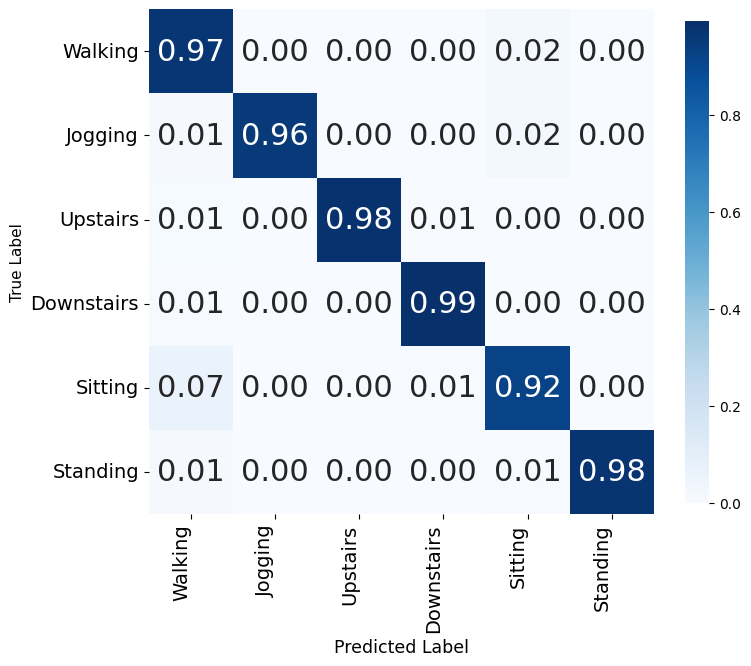

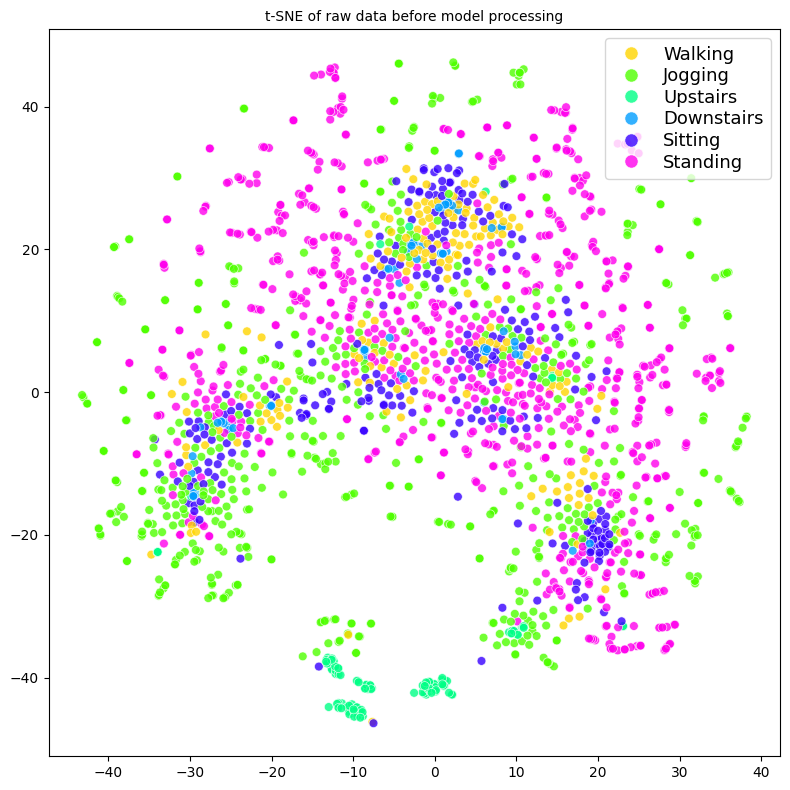


Running t-SNE on 2000 points (Perplexity=30)...


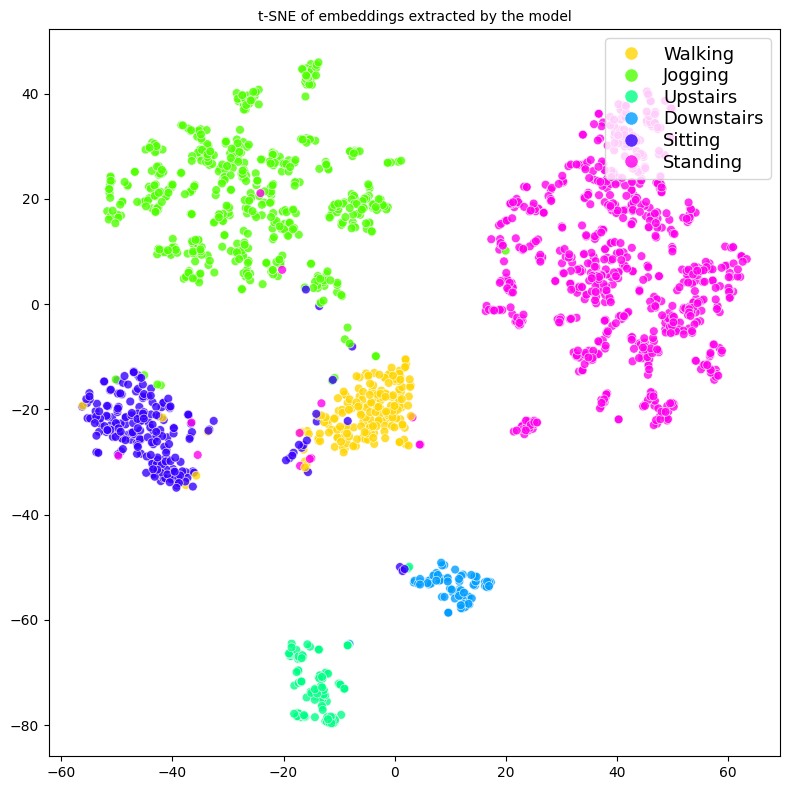

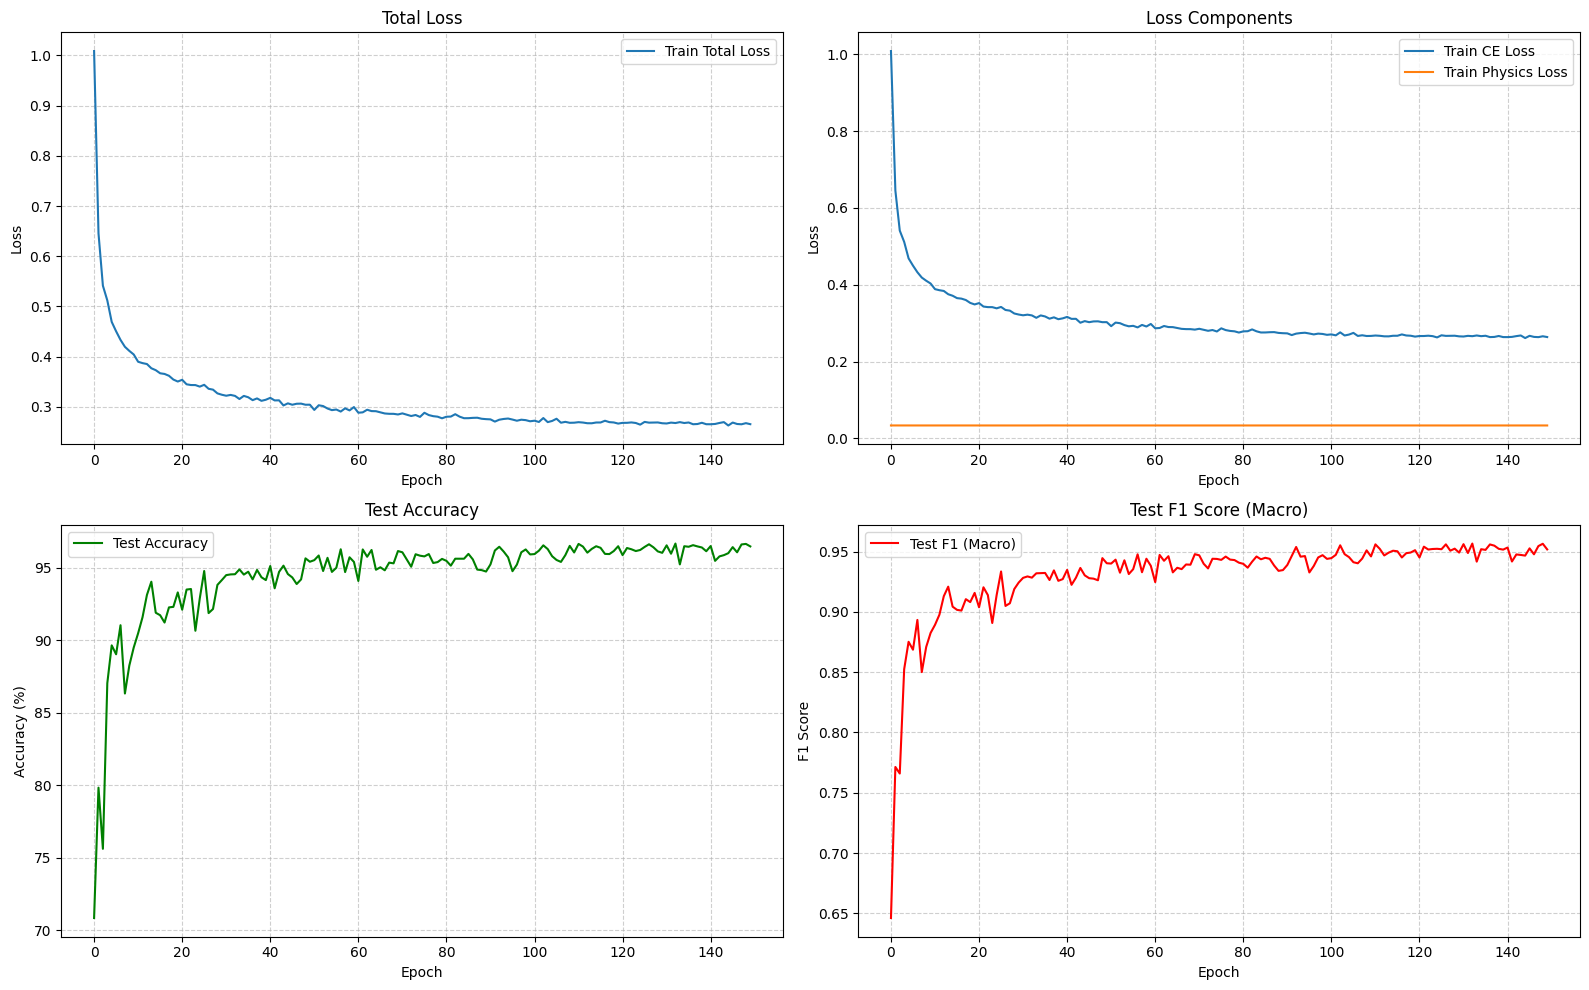

In [1]:
import os
import io
import time
import glob
import random
import contextlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt    

from sklearn.manifold import TSNE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, confusion_matrix, classification_report    

try:
    from fvcore.nn import FlopCountAnalysis
    FVCORE_AVAILABLE = True
except ImportError:
    FlopCountAnalysis = None
    FVCORE_AVAILABLE = False

# ========================
# SEED 고정 함수
# ========================
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # CUDA 11+

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=False)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

# ========================
# WISDM 데이터 로드 
# ========================
class WISDMDataset(Dataset):
    """
    단일 WISDM txt 형식:
    subject,activity,timestamp,x,y,z;
    예) 33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
    """
    def __init__(self, file_path: str, window_size: int = 80, step_size: int = 40):
        super().__init__()
        self.file_path = file_path
        self.window_size = window_size
        self.step_size = step_size

        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"WISDM txt file not found: {file_path}")

        df = self._load_file(file_path)
        self.X, self.y, self.subjects = self._create_windows(df)

        self.unique_subjects = sorted(np.unique(self.subjects))

        print("=" * 80)
        print("Loaded WISDM dataset (single txt)")
        print(f"  X shape       : {self.X.shape}  (N, T, C)")
        print(f"  y shape       : {self.y.shape}  (N,)")
        print(f"  subjects shape: {self.subjects.shape} (N,)")
        print(f"  unique subjects: {self.unique_subjects}")
        print("=" * 80)

    def _load_file(self, file_path: str) -> pd.DataFrame:
        """원본 txt 한 개를 통째로 읽어서 DataFrame으로 변환."""
        with open(file_path, "r") as f:
            lines = f.readlines()

        rows = []
        for line in lines:
            line = line.strip()
            if not line:
                continue
            # 끝 세미콜론 제거
            line = line.replace(";", "")
            parts = line.split(",")

            # subject, activity, timestamp, x, y, z → 6개 아니면 스킵
            if len(parts) != 6:
                continue

            subj, act, ts, x, y, z = parts

            # x,y,z 중 하나라도 비어있으면 스킵
            if x.strip() == "" or y.strip() == "" or z.strip() == "":
                continue

            rows.append([subj, act, ts, x, y, z])

        if not rows:
            raise ValueError(f"No valid rows parsed from file: {file_path}")

        df = pd.DataFrame(rows, columns=["subject", "activity", "timestamp", "x", "y", "z"])

        # 문자열 → NaN 처리 후 숫자로 변환
        df = df.replace(["", "NaN", "nan"], np.nan).dropna(subset=["subject", "x", "y", "z"])

        df["subject"] = pd.to_numeric(df["subject"], errors="coerce")
        df["x"] = pd.to_numeric(df["x"], errors="coerce")
        df["y"] = pd.to_numeric(df["y"], errors="coerce")
        df["z"] = pd.to_numeric(df["z"], errors="coerce")

        df = df.dropna(subset=["subject", "x", "y", "z"])

        if df.empty:
            raise ValueError("After cleaning, WISDM DataFrame is empty. Check file format.")

        df["subject"] = df["subject"].astype(int)

        # activity 문자열 → 정수 라벨
        df["activity_id"] = df["activity"].astype("category").cat.codes

        return df

    def _create_windows(self, df: pd.DataFrame):
        """
        subject 별로 나눠서 sliding window 생성.
        X: (N, T, 3), y: (N,), subjects: (N,)
        """
        X_list, y_list, s_list = [], [], []

        for subj_id in sorted(df["subject"].unique()):
            df_sub = df[df["subject"] == subj_id]

            # 필요하면 여기서 activity별로도 끊을 수 있음 (원하면 확장 가능)
            data = df_sub[["x", "y", "z"]].to_numpy(dtype=np.float32)      # (L, 3)
            labels = df_sub["activity_id"].to_numpy(dtype=np.int64)        # (L,)
            L = len(df_sub)

            start = 0
            while start + self.window_size <= L:
                end = start + self.window_size

                window_x = data[start:end]          # (T, 3)
                window_y = labels[end - 1]          # 마지막 타임스텝 라벨

                X_list.append(window_x.T)           # (3, T)
                y_list.append(window_y)
                s_list.append(subj_id)

                start += self.step_size

        if len(X_list) == 0:
            raise ValueError("[WISDMDataset] No windows created. Try smaller window_size or check data.")

        X = np.stack(X_list, axis=0).astype(np.float32)  # (N, 3, T)
        y = np.array(y_list, dtype=np.int64)
        s = np.array(s_list, dtype=np.int64)

        # (N, 3, T) → (N, T, 3)
        X = X.transpose(0, 2, 1)
        return X, y, s

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx: int):
        return (
            torch.FloatTensor(self.X[idx]),          # (T, 3)
            torch.LongTensor([self.y[idx]])[0],
            self.subjects[idx],
        )

# ========================
# Modern TCN Components 
# ========================
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            padding=padding, dilation=dilation, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleConvBlock(nn.Module):
    def __init__(self, channels, kernel_sizes=[3, 5, 7], dilation=1, dropout=0.1):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = ((k - 1) * dilation) // 2
            branch = nn.ModuleDict({
                'conv': DepthwiseSeparableConv1d(channels, channels, k, dilation, padding),
                'norm': nn.BatchNorm1d(channels),
                'dropout': nn.Dropout(dropout)
            })
            self.branches.append(branch)
        self.fusion = nn.Conv1d(channels * len(kernel_sizes), channels, 1)

    def forward(self, x):
        outputs = []
        target_length = x.size(2)
        for branch in self.branches:
            out = branch['conv'](x)
            if out.size(2) != target_length:
                out = out[:, :, :target_length]
            out = branch['norm'](out)
            out = F.gelu(out)
            out = branch['dropout'](out)
            outputs.append(out)
        multi_scale = torch.cat(outputs, dim=1)
        return self.fusion(multi_scale)

class ModernTCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 7], dilation=1, dropout=0.1):
        super().__init__()
        
        # NOTE: kernel_sizes가 [7]처럼 단일 리스트로 들어오면 Single-scale이 됨
        self.multi_conv1 = MultiScaleConvBlock(
            in_channels if in_channels == out_channels else out_channels,
            kernel_sizes, dilation, dropout
        )
        
        # NOTE: kernel_sizes 중 가장 큰 값을 기준으로 padding
        max_k = max(kernel_sizes) if isinstance(kernel_sizes, list) else kernel_sizes
        padding = ((max_k - 1) * dilation) // 2
        
        self.conv2 = DepthwiseSeparableConv1d(
            out_channels, out_channels, max_k, dilation, padding
        )
        self.norm2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        target_length = x.size(2)
        if self.downsample is not None:
            x = self.downsample(x)
            residual = x
        
        out = self.multi_conv1(x)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        
        out = self.conv2(out)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        out = self.norm2(out)
        out = F.gelu(out)
        out = self.dropout2(out)
        return F.gelu(out + residual)

class SqueezeExcitation1d(nn.Module):
    def __init__(self, channels, reduction=5):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
    def forward(self, x):
        batch, channels, _ = x.size()
        squeeze = F.adaptive_avg_pool1d(x, 1).view(batch, channels)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation)).view(batch, channels, 1)
        return x * excitation

class LargeKernelConv1d(nn.Module):
    def __init__(self, channels, kernel_size=21):
        super().__init__()
        padding = kernel_size // 2
        self.depthwise = nn.Conv1d(
            channels, channels, kernel_size,
            padding=padding, groups=channels
        )
        self.norm = nn.BatchNorm1d(channels)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.norm(out)
        return out

# ========================
# Modern TCN Base 모델 
# ========================
class BaseModernTCNHAR(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
                 kernel_sizes=[3, 7], large_kernel=21, dropout=0.1, use_se=True):
        super().__init__()
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, 1)
        self.large_kernel_conv = LargeKernelConv1d(hidden_dim, large_kernel)
        self.tcn_blocks = nn.ModuleList()
        for i in range(n_layers):
            dilation = 2 ** i
            self.tcn_blocks.append(
                ModernTCNBlock(
                    hidden_dim, hidden_dim,
                    kernel_sizes=kernel_sizes,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.final_large_kernel = LargeKernelConv1d(hidden_dim, large_kernel)
        # self.final_large_kernel = nn.Identity()
        self.use_se = use_se
        if use_se:
            self.se = SqueezeExcitation1d(hidden_dim)
        self.norm_final = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.input_proj(x)
        x = self.large_kernel_conv(x)
        x = F.gelu(x)
        for block in self.tcn_blocks:
            x = block(x)
        x = self.final_large_kernel(x)
        x = F.gelu(x)
        if self.use_se:
            x = self.se(x)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x = self.norm_final(x)
        return self.head(x)

# ========================
# Physics-Guided Modern TCN HAR 
# ========================
class PhysicsModernTCNHAR(BaseModernTCNHAR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        hidden_dim = self.head.in_features

        self.gravity_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3)
        )

    def forward(self, x, return_gravity=False):
        x = x.transpose(1, 2)
        x_feat = self.input_proj(x)
        x_feat = F.gelu(self.large_kernel_conv(x_feat))
        for block in self.tcn_blocks:
            x_feat = block(x_feat)
        x_feat = F.gelu(self.final_large_kernel(x_feat))
        if self.use_se:
            x_feat = self.se(x_feat)

        pooled = F.adaptive_avg_pool1d(x_feat, 1).squeeze(-1)
        pooled = self.norm_final(pooled)
        logits = self.head(pooled)

        outs = [logits]

        if return_gravity:
            seq_feat = x_feat.transpose(1, 2)  # (B,T,C)
            gvec = self.gravity_head(seq_feat)   # (B,T,3)
            outs.append(gvec)

        return tuple(outs) if len(outs) > 1 else outs[0]

# ========================
# Physics Loss (acc-only)
# ========================
def fir_lpf_hann_bt3(x,K=31):
    B,T,C = x.shape

    xc = x.transpose(1,2)

    w = torch.hann_window(K, device=x.device, dtype=x.dtype)
    w = (w/w.sum()).view(1,1,-1).expand(C,1,-1)

    a_lp = F.conv1d(xc,w,padding=K//2,groups=C).transpose(1,2)

    return a_lp, x - a_lp

def unit_norm(v,eps=1e-8): return v/(v.norm(dim=-1,keepdim=True)+eps)

def diff1(x): d=x[:,1:]-x[:,:-1]; return torch.cat([torch.zeros_like(d[:,:1]),d],1)

def physics_loss_wisdm(X_raw,g_pred,lambdas,params):
    acc = X_raw[:,:,:3]
    eps=1e-8
    a_lp,a_hp = fir_lpf_hann_bt3(acc,K=params.get("K",31))

    g_from_acc = unit_norm(a_lp,eps)
    g_pred = unit_norm(g_pred,eps)

    acc_norm=acc.norm(-1)
    hp_norm=a_hp.norm(-1)

    g0=params.get("g0",1.0)

    tau_a=params.get("tau_a",0.5)
    tau_g=params.get("tau_g",0.3)

    gate=((hp_norm<tau_a)&((acc_norm-g0).abs()<tau_g)).float()
    gate_sum=gate.sum()+1e-6

    cos=(g_from_acc*g_pred).sum(-1).clamp(-1+1e-6,1-1e-6)

    L_grav=(gate*torch.acos(cos)).sum()/gate_sum
    L_gmag=(gate*(acc_norm-g0).pow(2)).sum()/gate_sum

    a_body=acc-g0*g_pred
    win=params.get("win_mean",24)
    a_body_m=fir_lpf_hann_bt3(a_body,K=max(3,2*(win//2)+1))[0]

    L_split=(gate*a_body_m.norm(-1)).sum()/gate_sum
    L_smooth=diff1(acc).pow(2).sum(-1).mean()

    dt=params.get("dt",1/20)
    dg=diff1(g_pred)/max(dt,1e-3)

    L_static=(gate*dg.norm(-1)).sum()/gate_sum
    L=(lambdas.get("grav",.2)*L_grav+
       lambdas.get("gmag",.05)*L_gmag+
       lambdas.get("split",.15)*L_split+
       lambdas.get("smooth",.02)*L_smooth+
       lambdas.get("static",.05)*L_static)
    
    return L,dict(grav=L_grav.item(),gmag=L_gmag.item(),split=L_split.item(),smooth=L_smooth.item(),static=L_static.item())


# ========================
# 헬퍼: 파라미터 카운트
# ========================
def get_n_params(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

# ========================
# '물리 기반' 학습 함수 (F1 Score 기준)
# ========================
def train_physics(model, train_loader, test_loader, device, n_classes, epochs=50, lambda_phys=0.05, log_every=1):
    """
    lambda_phys: 총 물리손실 스케일 (각 항 상대가중치는 내부 lambdas)
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    base_lambdas_wisdm = dict(
        grav   = 0.20,
        split  = 0.15,
        gmag   = 0.05,
        smooth = 0.02,
        static = 0.05,
    )

    params_wisdm = dict(
        tau_a    = 0.5,
        tau_g    = 0.3,
        win_mean = 24,
        dt       = 1/20,   # WISDM ~20Hz
        g0       = 1.0,
        K        = 31,
    )

    best_f1 = best_acc = 0.0
    history = {"train_ce": [], "train_phys": [], "train_total": [], "test_acc": [], "test_f1": []}

    warm_epochs = 15
    best_state = None
    best_eval_cache = None

    for epoch in range(1, epochs + 1):
        model.train()
        ce_sum = phys_sum = total_sum = 0.0
        correct = total = 0

        # warm-up 스케일: 초반엔 λ_phys를 선형 증가
        if epoch <= warm_epochs:
            phys_scale = lambda_phys * (epoch / warm_epochs)
        else:
            phys_scale = lambda_phys

        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            logits, gvec = model(X, return_gravity=True)
            loss_ce = F.cross_entropy(logits, y, label_smoothing=0.05)
            L_phys, stats = physics_loss_wisdm(X, g_pred=gvec, lambdas=base_lambdas_wisdm, params=params_wisdm)

            loss = loss_ce + phys_scale * L_phys
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            ce_sum += loss_ce.item(); phys_sum += L_phys.item(); total_sum += loss.item()
            preds = logits.argmax(1); correct += (preds == y).sum().item(); total += y.size(0)

        scheduler.step()

        n_batches = len(train_loader)
        ce_avg, phys_avg, total_avg = ce_sum/n_batches, phys_sum/n_batches, total_sum/n_batches
        train_acc = 100.0 * correct / total

        # ===== 평가 =====
        model.eval()
        test_correct = test_total = 0
        all_preds, all_y = [], []
        all_feats = []

        with torch.inference_mode():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)

                feats = model.input_proj(X.transpose(1, 2))
                feats = model.large_kernel_conv(feats)
                feats = F.gelu(feats)
                for block in model.tcn_blocks:
                    feats = block(feats)
                feats = model.final_large_kernel(feats)
                feats = F.gelu(feats)
                if model.use_se:
                    feats = model.se(feats)
                pooled = F.adaptive_avg_pool1d(feats, 1).squeeze(-1)
                pooled = model.norm_final(pooled)

                logits = model.head(pooled)
                preds = logits.argmax(1)

                test_correct += (preds == y).sum().item()
                test_total   += y.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())
                all_feats.append(pooled.cpu().numpy())

        test_acc = 100.0 * test_correct / test_total
        test_f1 = f1_score(all_y, all_preds, labels=list(range(n_classes)), average='macro', zero_division=0)
        best_acc = max(best_acc, test_acc)

        if test_f1 > best_f1 + 1e-9:
            best_f1 = test_f1
            best_acc = max(best_acc, test_acc)
            # CPU 텐서로 깊은 복사
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            # 베스트 시점 캐시 저장
            best_eval_cache = {
                "y":     np.array(all_y, dtype=np.int64),
                "preds": np.array(all_preds, dtype=np.int64),
                "feats": np.concatenate(all_feats, axis=0)  # (N, D)
            }

        history["train_ce"].append(ce_avg); history["train_phys"].append(phys_avg)
        history["train_total"].append(total_avg); history["test_acc"].append(test_acc); history["test_f1"].append(test_f1)

        if (epoch % log_every) == 0:
            print(f"[Physics*] Epoch {epoch:03d}/{epochs} | Train Acc={train_acc:.2f}% | "
                  f"CE={ce_avg:.4f} | Phys={phys_avg:.4f} (λ_total={phys_scale:.3f}) | "
                  f"Total={total_avg:.4f} || Test F1={test_f1:.4f} | Test Acc={test_acc:.2f}% "
                  f"(Best F1={best_f1:.4f}, Best Acc={best_acc:.2f}%)")

    return best_f1, best_acc, history, best_state, best_eval_cache  


# ========================
# 시각화 함수
# ========================
ACTIVITY_LABELS = [
    'Walking',
    'Jogging',
    'Upstairs',
    'Downstairs',
    'Sitting',
    'Standing'
]

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("hsv", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))

def plot_classification_results(y_true, y_pred, save_path=None):
    """
    Confusion Matrix 시각화 
    """
    # 1. Classification Report 출력
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVITY_LABELS,
            digits=4,
            zero_division=0,
        )
    )

    # 2. 정규화된 Confusion Matrix 계산 및 시각화
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                annot_kws={"size": 22}, cbar_kws={"shrink": 0.7},
                xticklabels=ACTIVITY_LABELS, yticklabels=ACTIVITY_LABELS)
    plt.xlabel('Predicted Label', fontsize=12.5)
    plt.ylabel('True Label', fontsize=11)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path
        plt.savefig(pdf_save_path, dpi=600)

    plt.show()
    plt.close()


def _extract_featvec_before_classifier(model, xb, device):
    """
    model.forward()의 흐름을 그대로 따라가되
    classifier 직전의 feature vector(feat_vec, shape (B, embed_dim))만 추출.
    이건 visualize_tsne에서 feature space로 쓸 거임.

    xb: (B, C_in, T) on CPU
    returns: (B, embed_dim) on CPU (no grad)
    """
    xb = xb.to(device)

    # 1. Embedding (+CBAM)
    x = model.embedding(xb)                  # (B, embed_dim, T)
    if model.use_cbam:
        x = model.cbam(x)                    # (B, embed_dim, T)

    # 2. 준비: (B, C, T) -> (B, T, C)
    x = x.transpose(1, 2).contiguous()       # (B, T, embed_dim)

    # 3. Dim reduction (optional)
    if model.use_dim_reduction:
        x = model.dim_reduce(x)              # (B, T, reduced_dim)

    # 4. Attention backbone
    if model.use_crossformer:
        # contrast 안 쓸 거라 proto_features 필요 없음
        # eval 시에는 실제 inference 경로로 skip_cross_attention=False 가 더 정직
        x = model.crossformer(
            x,
            return_proto_features=False,
            skip_cross_attention=False
        )                                    # (B, T, working_dim)
    else:
        # fallback self-attention
        x = model.self_attn(x)               # (B, T, working_dim)

    # 5. Dim restore (optional)
    if model.use_dim_reduction:
        x = model.dim_restore(x)             # (B, T, embed_dim)

    # 6. Pooling과 동일하게 처리
    # (B, T, embed_dim) -> (B, embed_dim, T)
    x = x.transpose(1, 2).contiguous()       # (B, embed_dim, T)
    feat_vec = model.pool(x).squeeze(-1)     # (B, embed_dim)

    return feat_vec.detach().cpu()           # CPU로 반환, grad 없이

def plot_tsne_from_cached_features(feats, labels, save_path=None, max_points=2000):
    """
    train_physics에서 저장한 best_eval["feats"]와 best_eval["y"]를
    받아서 t-SNE로 시각화합니다.
    """
    all_features = feats  # (N, D)
    all_labels = labels    # (N,)

    # 샘플 수 줄이기
    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]  # (M, D)
    y_sel = all_labels[idx]    # (M,)

    # perplexity는 (샘플 수 - 1)보다 작아야 함
    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning t-SNE on {len(X_sel)} points (Perplexity={effective_perp})...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_sel)  # (M, 2)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of embeddings extracted by the model", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=150)

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, save_path=None, max_points=2000):
    """
    모델을 거치기 전의 raw window (shape: B x C x T)를 flatten해서 t-SNE로 투영.

    - dataloader: 보통 val_loader나 test_loader 넣는 걸 추천 (train 넣으면 class 간경계 너무 깨끗하게 나오는 경우 많음)
    - max_points: t-SNE에 사용할 최대 샘플 수
    """
    all_raw = []
    all_labels = []

    for xb, yb, _ in dataloader:
        all_raw.append(xb.cpu().numpy())     # (B, C, T)
        all_labels.append(yb.cpu().numpy())  # (B,)

    all_raw = np.concatenate(all_raw, axis=0)       # (N, C, T)
    all_labels = np.concatenate(all_labels, axis=0) # (N,)

    # 샘플 수 줄이기
    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]    # (M, C, T)
    y_sel = all_labels[idx] # (M,)

    # flatten: (M, C*T)
    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40, 
    )
    plt.title("t-SNE of raw data before model processing", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path
        plt.savefig(pdf_save_path, bbox_inches="tight")

    plt.show()
    plt.close()


def plot_history(history, save_path=None):
    """
    train_physics에서 반환된 history 딕셔너리를 시각화합니다.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Total Loss
    axes[0, 0].plot(history['train_total'], label='Train Total Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Loss Components
    axes[0, 1].plot(history['train_ce'], label='Train CE Loss')
    axes[0, 1].plot(history['train_phys'], label='Train Physics Loss')
    axes[0, 1].set_title('Loss Components')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Test Accuracy
    axes[1, 0].plot(history['test_acc'], label='Test Accuracy', color='green')
    axes[1, 0].set_title('Test Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Test F1 Score
    axes[1, 1].plot(history['test_f1'], label='Test F1 (Macro)', color='red')
    axes[1, 1].set_title('Test F1 Score (Macro)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
        
    plt.show()
    plt.close()

# =================================================================================
# Model profiling: Param(M), FLOPs(M), Inference Time(ms)
# =================================================================================
def profile_model(model,
                  sample_input: torch.Tensor,
                  device: torch.device,
                  warmup: int = 10,
                  iters: int = 50):
    """
    모델 구조/비용 측정:
      - 파라미터 수 (M 단위)
      - FLOPs per sample (M 단위, fvcore 있으면)
      - 평균 추론 시간 (ms / sample)

    fvcore가 stdout/stderr에 시끄럽게 프린트하는 걸 다 먹어버린다.
    """

    model = model.to(device)
    model.eval()

    # -------------------------------------------------
    # 1) 파라미터 수
    # -------------------------------------------------
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1e6  # million params

    # -------------------------------------------------
    # 2) FLOPs 측정 (fvcore 사용 가능할 때만)
    #    - 모든 stdout/stderr을 임시 버퍼로 리다이렉트해서
    #      "Unsupported operator ..." 같은 중얼거림을 완전히 감춘다.
    # -------------------------------------------------
    flops_m = None
    if "FVCORE_AVAILABLE" in globals() and FVCORE_AVAILABLE and FlopCountAnalysis is not None:
        try:
            with torch.no_grad():
                fake_out = io.StringIO()
                fake_err = io.StringIO()
                with contextlib.redirect_stdout(fake_out), contextlib.redirect_stderr(fake_err):
                    flops = FlopCountAnalysis(model, (sample_input.to(device),))
                    total_flops = flops.total()
            flops_m = total_flops / 1e6  # to millions
        except Exception:
            flops_m = None
    else:
        flops_m = None

    # -------------------------------------------------
    # 3) 추론 시간 측정
    # -------------------------------------------------
    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(iters):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    avg_sec = (end - start) / iters
    inference_ms = avg_sec * 1000.0

    return {
        "params_m": params_m,
        "flops_m": flops_m,
        "inference_ms": inference_ms,
    }



def print_model_profile(stats_dict):
    print("=" * 80)
    print(f"Parameters      : {stats_dict['params_m']:.4f} M")
    print(f"FLOPs / sample : {stats_dict['flops_m']:.3f} M")
    print(f"Infer Time     : {stats_dict['inference_ms']:.2f} ms/sample")
    print("=" * 80)

# ========================
# 메인 실행 함수 (Ablation Study)
# ========================
def main():
    set_seed(42) 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    data_path = 'C://Users/park9/ModernTCN_Physics/data/WISDM_ar_v1.1_raw.txt'

    try:
        # UCIHARDataset 대신 WISDMDataset 사용 (전체 데이터 한 번에 로드)
        full_ds = WISDMDataset(data_path, window_size=80, step_size=40)  # ★ 네가 정의한 파라미터에 맞춰서
    except FileNotFoundError:
        print(f"Error: 데이터셋을 찾을 수 없습니다. 'data_path' 변수를 수정하세요.")
        print(f"현재 경로: {data_path}")
        return
    
    # ==========================================================
    # 2) ★★★ Random train/test split (Subject-agnostic) ★★★
    #    (Subject-wise 및 Undersampling 로직 제거)
    # ==========================================================
    
    N_CLASSES = len(np.unique(full_ds.y))
    print("Num classes (WISDM):", N_CLASSES)

    # --- Random Split 사용 ---
    total_samples = len(full_ds)
    train_ratio = 0.7
    n_train_samples = int(total_samples * train_ratio)
    n_test_samples = total_samples - n_train_samples

    print(f"Total samples: {total_samples}")
    print(f"Splitting into {n_train_samples} train and {n_test_samples} test samples (Randomly).")

    # 재현 가능하도록 generator로 시드 고정
    generator = torch.Generator().manual_seed(42)
    train_ds, test_ds = torch.utils.data.random_split(
        full_ds, 
        [n_train_samples, n_test_samples], 
        generator=generator
    )
    # --- 변경 완료 ---

    print(f"Train samples: {len(train_ds)}")
    print(f"Test samples : {len(test_ds)}")

    # (선택 사항) 분할된 학습셋의 라벨 분포 확인
    print("\nTrain set label distribution (after random split):")
    print(pd.Series(full_ds.y[train_ds.indices]).value_counts().sort_index())
    print("-" * 60)

    # ============================
    # 3) train set 통계로 정규화
    # ============================
    # (random_split이 반환하는 train_ds를 사용합니다)
    def compute_train_stats(subset):
        X_train = torch.from_numpy(subset.dataset.X[subset.indices]).float()
        mean = X_train.mean(dim=(0, 1), keepdim=True)
        std  = X_train.std(dim=(0, 1), keepdim=True).clamp_min(1e-6)
        return mean, std

    mean, std = compute_train_stats(train_ds)

    # ============================
    # 4) DataLoaders 생성
    # ============================
    def make_loaders(train_ds, test_ds, mean, std, batch_size=64, seed=42):
        def collate_norm(batch):
            X, y, s = zip(*batch)
            X = torch.stack(X, dim=0).float()      # (B, T, C)
            X = (X - mean) / std                   # ★ z-score 정규화
            y = torch.tensor(y, dtype=torch.long)
            s = torch.tensor(s, dtype=torch.long)
            return X, y, s

        g = torch.Generator()
        g.manual_seed(seed)

        train_loader = DataLoader(
            train_ds, batch_size=batch_size, shuffle=True, # ★ random split 된 train_ds
            generator=g, num_workers=0, drop_last=True,
            pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
        )
        test_loader = DataLoader(
            test_ds, batch_size=batch_size, shuffle=False, # ★ random split 된 test_ds
            num_workers=0, drop_last=False,
            pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
        )
        return train_loader, test_loader

    # ★★★ random split으로 나뉜 train_ds, test_ds로 로더 생성 ★★★
    train_loader, test_loader = make_loaders(train_ds, test_ds, mean, std, seed=42)
    # ============================
    # 3) train set 통계로 정규화
    # ============================
    def compute_train_stats(subset):
        # subset.dataset.X: (N_total, T, C)
        X_train = torch.from_numpy(subset.dataset.X[subset.indices]).float()
        mean = X_train.mean(dim=(0, 1), keepdim=True)
        std  = X_train.std(dim=(0, 1), keepdim=True).clamp_min(1e-6)
        return mean, std

    mean, std = compute_train_stats(train_ds)

    # 원본 train_ds의 인덱스와 라벨 가져오기
    original_train_indices = train_ds.indices
    original_train_labels = full_ds.y[original_train_indices]

    # imblearn은 (n_samples, n_features) 형태를 기대합니다.
    # X는 실제 데이터가 아니라, 나중에 인덱스를 다시 뽑기 위한 "위치 홀더"입니다.
    # (샘플 수, 1) 크기의 인덱스 배열을 생성합니다.
    X_indices_placeholder = np.arange(len(original_train_indices)).reshape(-1, 1)
    y_labels = original_train_labels

    rus = RandomUnderSampler(random_state=42)
    # X_indices_placeholder를 샘플링합니다.
    resampled_local_indices, _ = rus.fit_resample(X_indices_placeholder, y_labels)
    
    # resampled_local_indices는 0 ~ (N-1) 사이의 *로컬 인덱스*입니다.
    # 이를 full_ds에 대한 *실제(글로벌) 인덱스*로 다시 매핑합니다.
    resampled_global_indices = np.array(original_train_indices)[resampled_local_indices.flatten()]
    
    print(f"Resampled train samples: {len(resampled_global_indices)}")
    
    # (선택 사항) 라벨 분포 확인
    print("\nOriginal label distribution (Train):")
    print(pd.Series(original_train_labels).value_counts().sort_index())
    print("\nResampled label distribution (Train):")
    print(pd.Series(full_ds.y[resampled_global_indices]).value_counts().sort_index())
    print("-" * 60)

    # ★ 언더샘플링된 인덱스로 *새로운* 학습용 Subset 생성
    train_ds = Subset(full_ds, resampled_global_indices)


    def make_loaders(train_ds, test_ds, mean, std, batch_size=64, seed=42):
        def collate_norm(batch):
            X, y, s = zip(*batch)
            X = torch.stack(X, dim=0).float()      # (B, T, C)
            X = (X - mean) / std                   # ★ WISDM도 z-score 정규화
            y = torch.tensor(y, dtype=torch.long)
            s = torch.tensor(s, dtype=torch.long)
            return X, y, s

        g = torch.Generator()
        g.manual_seed(seed)

        train_loader = DataLoader(
            train_ds, batch_size=batch_size, shuffle=True,
            generator=g, num_workers=0, drop_last=True,
            pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
        )
        test_loader = DataLoader(
            test_ds, batch_size=batch_size, shuffle=False,
            num_workers=0, drop_last=False,
            pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
        )
        return train_loader, test_loader

    train_loader, test_loader = make_loaders(train_ds, test_ds, mean, std, seed=42)
    
    EPOCHS = 150 # 공통 Epoch
    N_CLASSES = len(np.unique(full_ds.y))
    results = {} # 결과 저장 딕셔너리

    # ---
    # Full Model
    # ---
    set_seed(42)
    train_loader, test_loader = make_loaders(train_ds, test_ds, mean, std, seed=42)
    model = PhysicsModernTCNHAR( 
        input_dim=3, hidden_dim=64, n_layers=3, 
        n_classes=N_CLASSES,
        kernel_sizes=[3, 7], 
        large_kernel=19, 
        dropout=0.5,
        use_se=True         
    ).to(device)
    print(f"  - Parameters: {get_n_params(model)}")

    # ========================
    # 모델 프로파일링
    # ========================
    # (B, T, C) -> (1, 128, 9)
    sample_input_shape = (1, 80, 3) 
    sample_input = torch.randn(sample_input_shape).to(device)
    
    # profile_model은 (B, T, C) 입력을 받아 model(x)를 호출합니다.
    profile_stats = profile_model(model, sample_input, device)
    print_model_profile(profile_stats)

    # ========================
    # 모델 학습
    # ========================
    f1_3, acc_3, hist, best_state, best_eval = train_physics(model, train_loader, test_loader, device, N_CLASSES, 
                                                             epochs=EPOCHS, lambda_phys=0.05, log_every=25) 
    
    # ========================
    # 결과 시각화
    # ========================
    # 1. Classification Report & Confusion Matrix (PNG 저장)
    plot_classification_results(
        best_eval["y"], 
        best_eval["preds"], 
        save_path="cm_wisdm.png" 
    )

    # 2. t-SNE (Raw Data)
    visualize_tsne_raw(
        test_loader, 
        save_path="tsne_raw_wisdm.png" 
    )

    # 3. t-SNE (Model Features) (새 함수 호출)
    plot_tsne_from_cached_features(
        best_eval["feats"],
        best_eval["y"],
        save_path="tsne_model_wisdm.png" 
    )

    # 4. 학습 이력 (새 함수 호출)
    plot_history(
        hist, 
        save_path="history_wisdm.png" 
    )

if __name__ == '__main__':
    main()